In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, metrics

from mlxtend.plotting import plot_decision_regions 
import tensorflow as tf

%matplotlib inline

/Users/abulbasar/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

In [2]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv")
df_test = pd.read_csv("/data/MNIST/mnist_test.csv")

In [6]:
X_train = df_train.iloc[:, 1:].values.astype(np.float32)
X_test = df_test.iloc[:, 1:].values.astype(np.float32)

scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
y_train = df_train.values[:, 0]
y_test = df_test.values[:, 0]

X Tensor("X:0", shape=(?, 784), dtype=float32)
y Tensor("y:0", shape=(?,), dtype=int32)
y_prob Tensor("Softmax:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
accuracy Tensor("Mean:0", shape=(), dtype=float32)
3.43657
0.298586
0.188347
0.0916157
0.0802999
0.0972332
0.0878357
0.0555505
0.0488296
0.0378444
0.0766398
test accuracy 0.968697


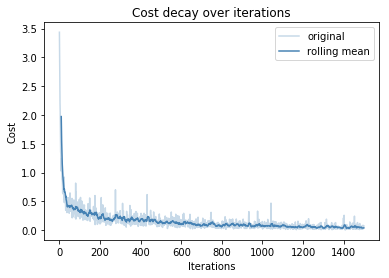

In [17]:
tf.reset_default_graph()
tf.set_random_seed(1)
n_x = X_train_std.shape[1]
n_y = 10
n_h = 200
max_iters = 1500

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name="X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name="y")

y_oh = tf.one_hot(indices=y, depth=n_y)

print("X", X)
print("y", y)


def full_layer(input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.Variable(tf.truncated_normal(stddev=0.1, shape=[input_size, size]))
    b = tf.Variable(tf.constant(0.1, shape=[size]))
    Z = tf.matmul(input, W) + b
    if not activation is None:
        Z = activation(Z)
    return Z
    

layer1 = full_layer(X, n_h, tf.nn.relu)
layer2 = full_layer(layer1, n_h, tf.nn.relu)
Z_out = full_layer(layer2, n_y)

y_prob = tf.nn.softmax(Z_out)
print("y_prob", y_prob)

y_pred = tf.argmax(Z_out, axis=1, output_type=tf.int32)
print("y_pred", y_pred)


accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

print("accuracy", accuracy)

loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, 
                                            logits=Z_out)
cost = tf.reduce_mean(loss)

optimization = tf.train\
            .AdamOptimizer(learning_rate=0.001)\
            .minimize(cost)

with tf.Session() as sess:
    scores = {}
    sess.run(tf.global_variables_initializer())
    batchable = Batchable(X_train_std, y_train, batch_size=128)
    for i in range(max_iters):
        X_batch, y_batch = batchable.next()
        cost_, _ = sess.run([cost, optimization], 
                feed_dict={X: X_batch, y:y_batch})
        scores[i] = cost_
        if i % (max_iters // 10) == 0 or i == max_iters-1:
            print(cost_)
    plot_scores(scores) 
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})
    print("test accuracy", accuracy_)
    y_test_pred = sess.run(y_pred, feed_dict={X: X_test_std})

In [33]:
result = pd.DataFrame({"predict": y_test_pred, "actual": y_test})
result["match"] = np.where(result.actual == result.predict, 1, 0)
result = result.groupby(["actual", "match"]).count().unstack()
result["ratio"] = result.iloc[:, 0] / result.iloc[:, 1]
result

predict           ratio
match        0     1          
actual                        
0           17   963  0.017653
1           10  1125  0.008889
2           40   992  0.040323
3           29   981  0.029562
4           23   959  0.023983
5           40   852  0.046948
6           20   938  0.021322
7           34   993  0.034240
8           33   941  0.035069
9           67   942  0.071125

In [36]:
result = pd.DataFrame({"predict": y_test_pred, "actual": y_test})
result["match"] = np.where(result.actual == result.predict, 1, 0)
matched = result.match
wrong_idx = matched[matched == 0].index

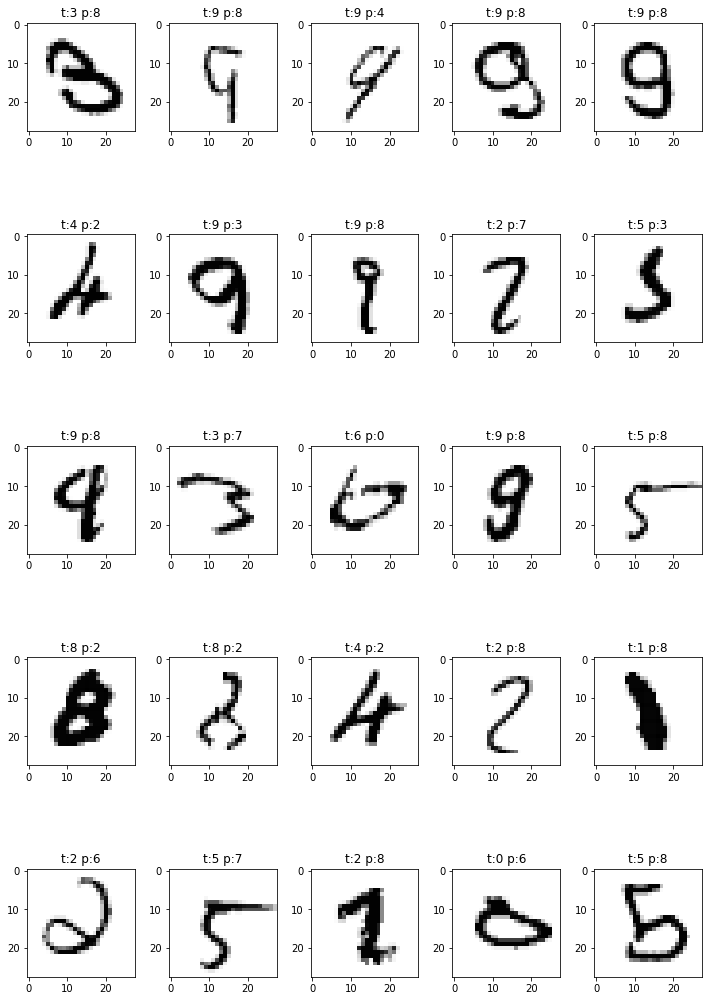

In [45]:
fig, _ = plt.subplots(5, 5, figsize = (10, 15))
for i, ax in enumerate(fig.axes):
    index = wrong_idx[i]
    ax.imshow(X_test[index, :].reshape(28, 28), cmap = "Greys")
    ax.set_title("t:" +  str(y_test[index])
                            + " p:" +  str(y_test_pred[index]))
    
plt.tight_layout()

In [46]:
len(wrong_idx)

313